In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import kagglehub
import os

In [ ]:


path = kagglehub.dataset_download("kaushiksuresh147/customer-segmentation")

print("Path to dataset files:", path)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv(f"{path}/Train.csv")
test_df = pd.read_csv(f"{path}/Test.csv")

100%|██████████| 99.9k/99.9k [00:00<00:00, 47.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kaushiksuresh147/customer-segmentation/versions/31


In [ ]:
df = pd.concat([train_df, test_df])
df.duplicated().sum()


38

In [ ]:
print(df.info(verbose=True, show_counts=True), df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB
None 38


In [ ]:
df.drop_duplicates(inplace=True)

number_imputer = SimpleImputer(strategy='mean')
category_imputer = SimpleImputer(strategy='most_frequent')

numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

df_num = pd.DataFrame(
    number_imputer.fit_transform(df[numerical_cols]), columns=numerical_cols
)
df_cat = pd.DataFrame(
    category_imputer.fit_transform(df[categorical_cols]), columns=categorical_cols
)
df=pd.concat([df_num, df_cat], axis=1)

df.drop(["ID"], axis=1, inplace=True)

#Create dummies
df = pd.concat([df, pd.get_dummies(df["Gender"], prefix="Gender")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Ever_Married"], prefix="Ever_Married")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Graduated"], prefix="Graduated")], axis=1)
df = pd.concat([df, pd.get_dummies(df["Profession"], prefix="Profession")], axis=1)

df["Spending_Score_Level"] = df["Spending_Score"].apply(lambda x: ["Low", "Average", "High"].index(x))+1 #Label encoding
df = pd.concat([df, pd.get_dummies(df["Var_1"], prefix="Var_1")], axis=1)
#target variable for the ML model (label encoding)
df["Segmentation_Level"] = df["Segmentation"].apply(lambda x: ["A", "B", "C", "D"].index(x))+1 #Label encoding
#target variable for the DL model (one-hot encoding)
df = pd.concat([df, pd.get_dummies(df["Segmentation"], prefix="Segmentation")], axis=1)
# Segmentation_encoding_dl = np.asarray(auto_ds[["Segmentation_A", "Segmentation_B", "Segmentation_C", "Segmentation_D"]])
#creating for the DL model the response variable through the concatenation of the created dummy columns, forming an array

df["Work_Experience_to_Age_Ratio"] = df["Work_Experience"] / df["Age"]


df["Age_Range"] = (
    np.where(df.Age>=60, "60+", np.where(df.Age>=50, "50-60", np.where(df.Age>=40, "40-50", np.where(df.Age>=30, "30-40", np.where(df.Age>=18, "18-30", "18-"))))))
df["Work_Experience_Range"] = (
    np.where(df.Work_Experience>=10, "10+", np.where(df.Work_Experience>=5, "5-10", "0-5")))
df["Family_Size_Range"] = (
    np.where(df.Family_Size>=6, "6+", np.where(df.Family_Size>=3, "3-6", "0-3")))
df["Work_Experience_to_Age_Ratio_Range"] = (
    np.where(df.Work_Experience_to_Age_Ratio>=0.05, "0.1+", np.where(df.Work_Experience_to_Age_Ratio>=0.04, "0.04-0.05", np.where(df.Work_Experience_to_Age_Ratio>=0.03, "0.03-0.04", np.where(df.Work_Experience_to_Age_Ratio>=0.02, "0.02-0.03", np.where(df.Work_Experience_to_Age_Ratio>=0.01, "0.01-0.02", "0+"))))))

df.to_csv("df_clean.csv")
print(df.isna().sum())
print(df.head(15))

Age                                   0
Work_Experience                       0
Family_Size                           0
Gender                                0
Ever_Married                          0
Graduated                             0
Profession                            0
Spending_Score                        0
Var_1                                 0
Segmentation                          0
Gender_Female                         0
Gender_Male                           0
Ever_Married_No                       0
Ever_Married_Yes                      0
Graduated_No                          0
Graduated_Yes                         0
Profession_Artist                     0
Profession_Doctor                     0
Profession_Engineer                   0
Profession_Entertainment              0
Profession_Executive                  0
Profession_Healthcare                 0
Profession_Homemaker                  0
Profession_Lawyer                     0
Profession_Marketing                  0


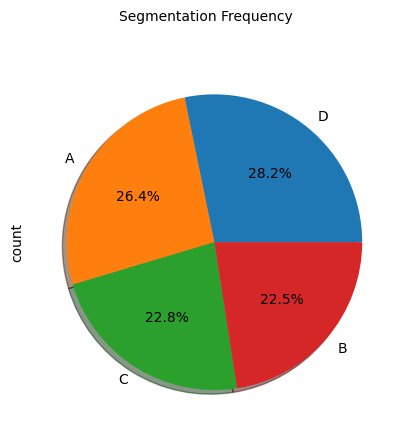

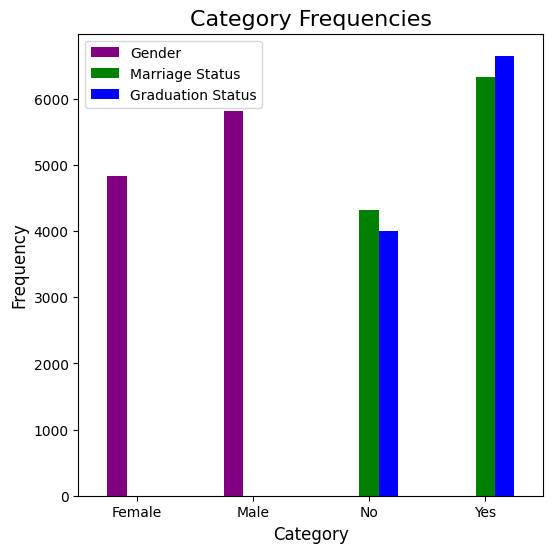

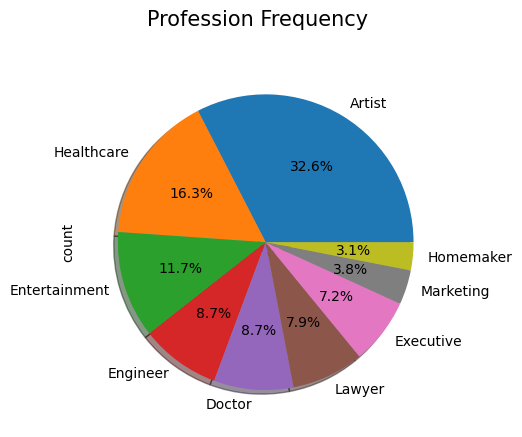

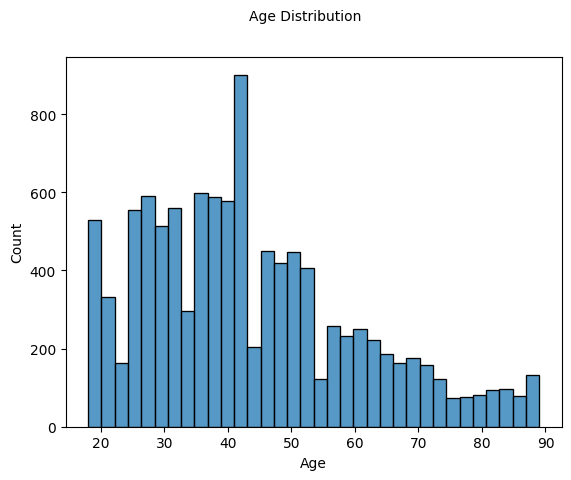

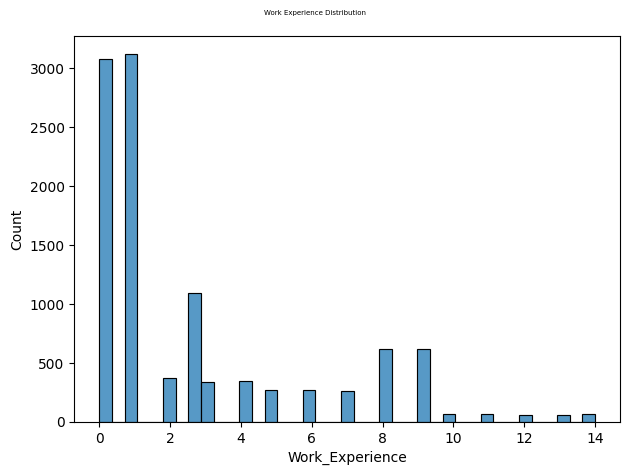

In [ ]:
fig, ax = plt.subplots(1, 1)  # Only one subplot for the pie chart
df["Segmentation"].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, textprops={"fontsize": 10}, ax=ax)
fig.suptitle("Segmentation Frequency", fontsize=10)
plt.xticks(rotation=90)  # You can remove or modify this line if it's unnecessary
plt.yticks(rotation=45)

df_counts = pd.DataFrame({
    'Gender': df["Gender"].value_counts(),
    'Marriage Status': df["Ever_Married"].value_counts(),
    'Graduation Status': df["Graduated"].value_counts()
})

df_counts.plot.bar(color=["purple", "green", "blue"], figsize=(6, 6))
plt.title("Category Frequencies", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=0)

fig, ax = plt.subplots(1, 1)
df["Profession"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax)
fig.suptitle("Profession Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

fig, ax = plt.subplots(1,1)
fig.suptitle("Age Distribution", fontsize=10)
sns.histplot(df["Age"], ax=ax)

fig, ax = plt.subplots(1,1)
fig.suptitle("Work Experience Distribution", fontsize=5)
sns.histplot(df["Work_Experience"], ax=ax)




# Show the plot
plt.tight_layout()
plt.show()


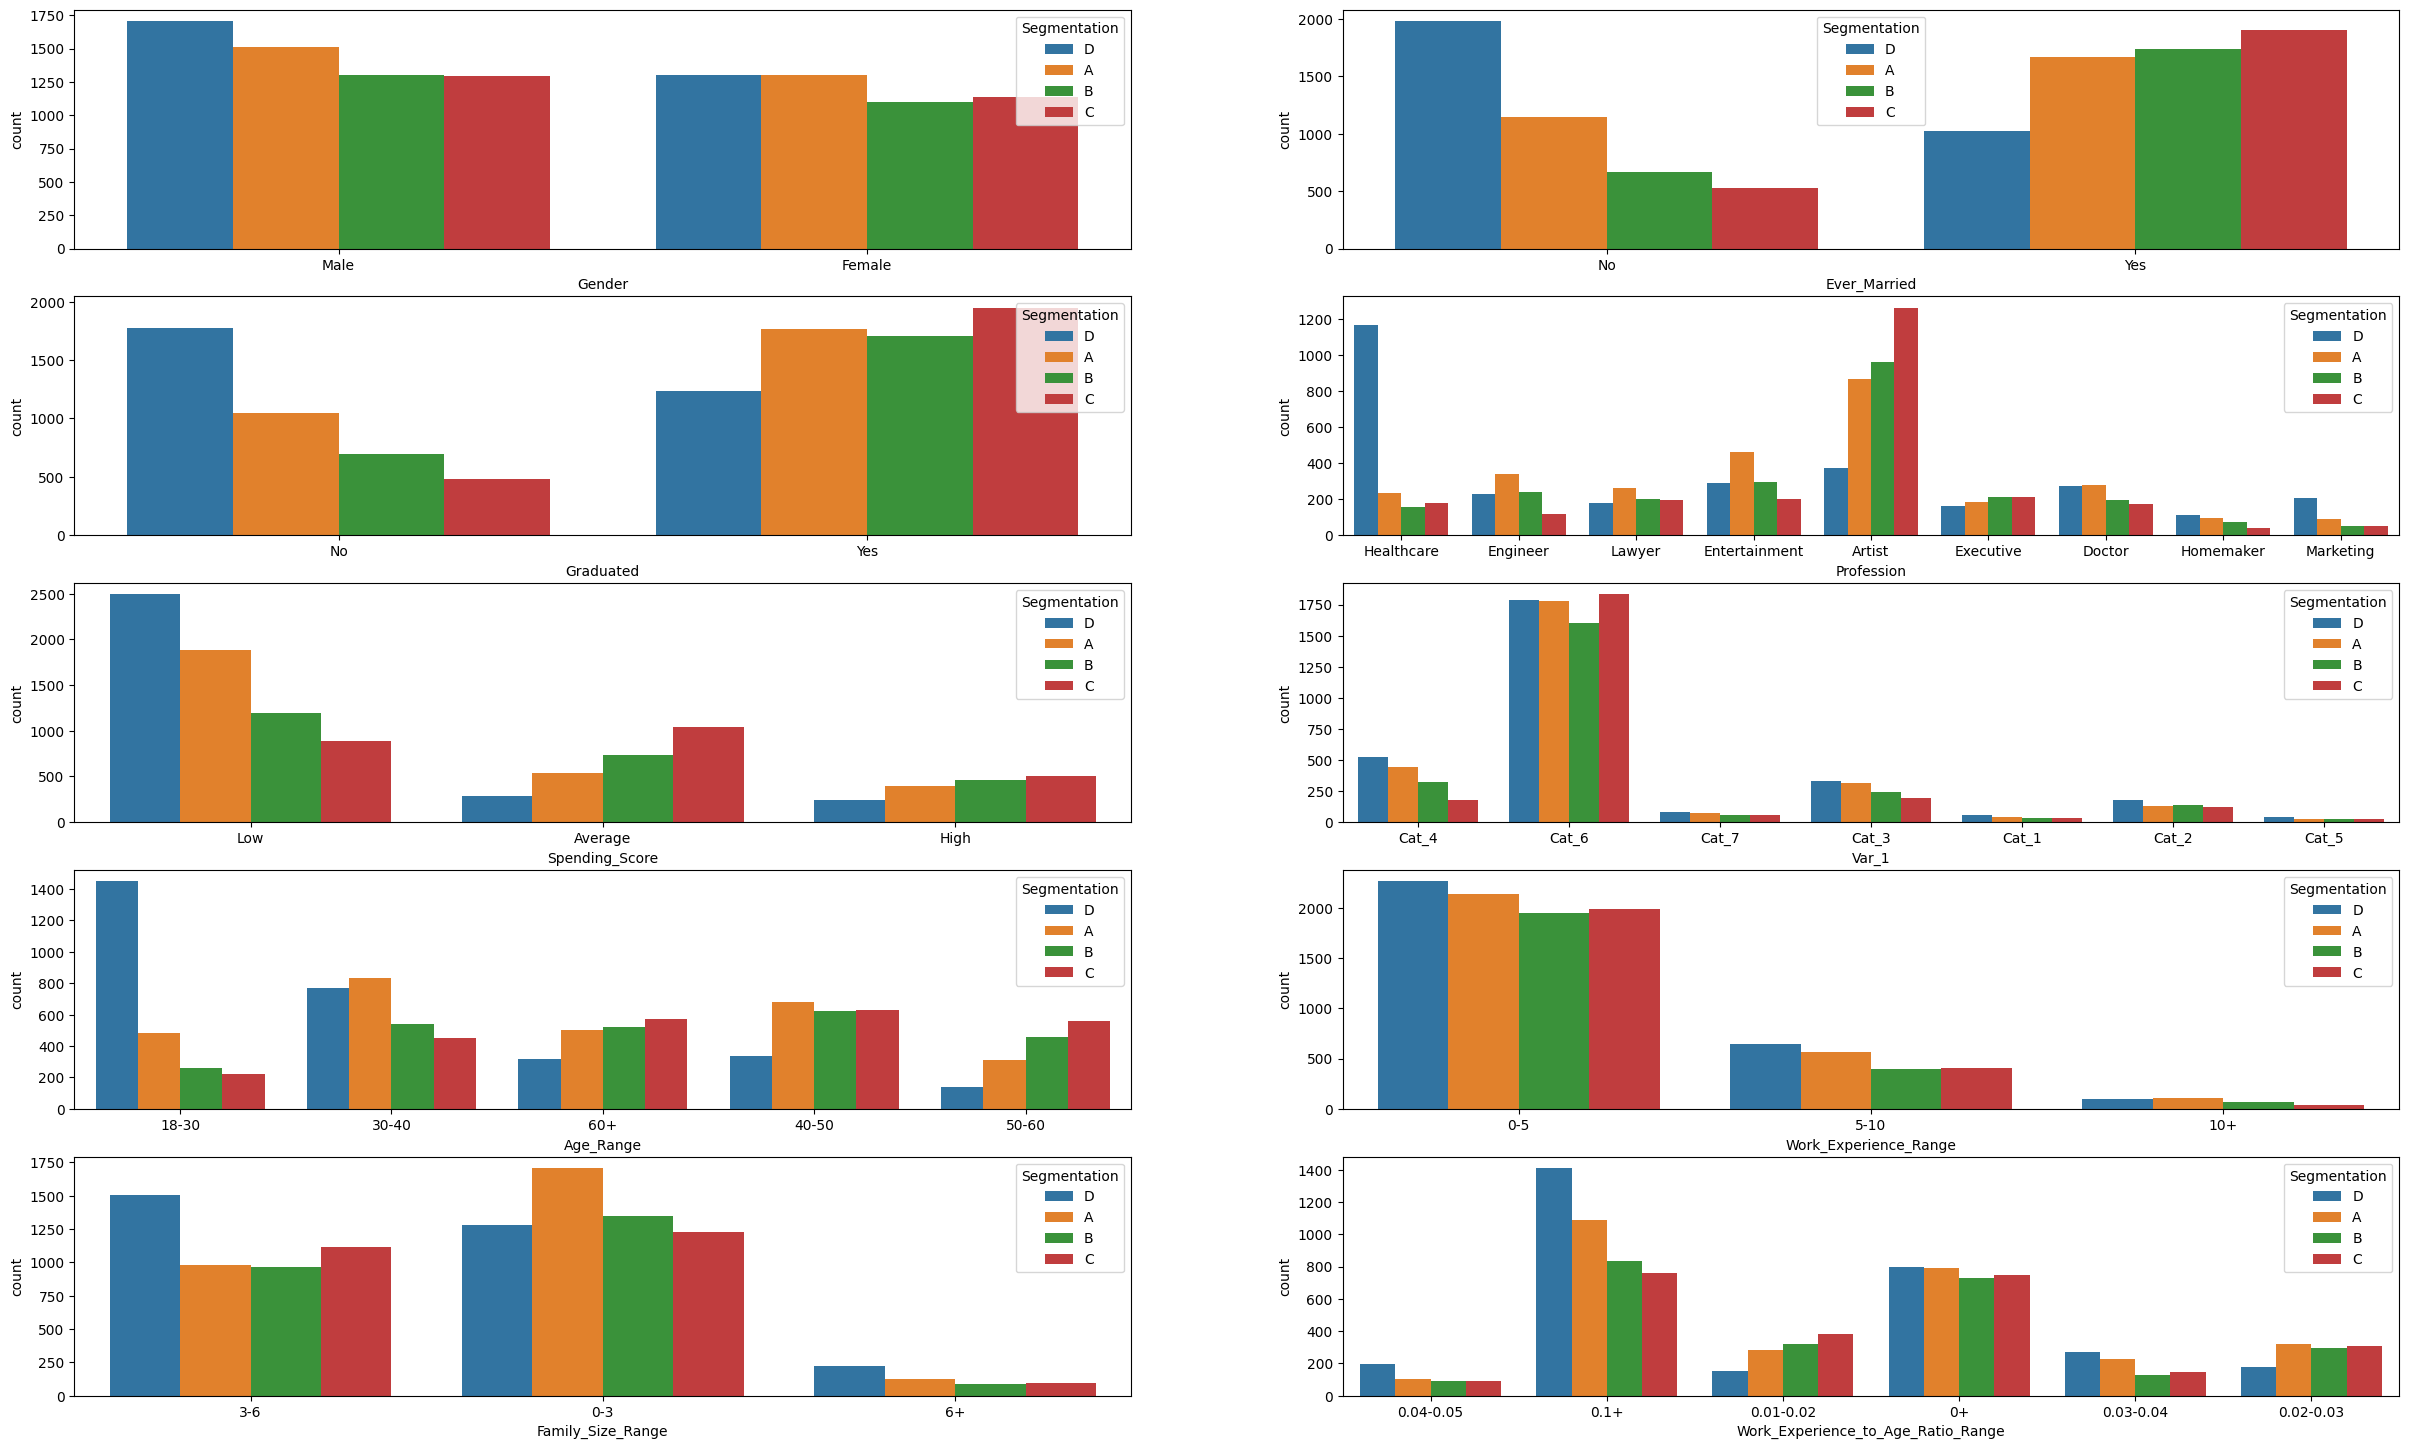

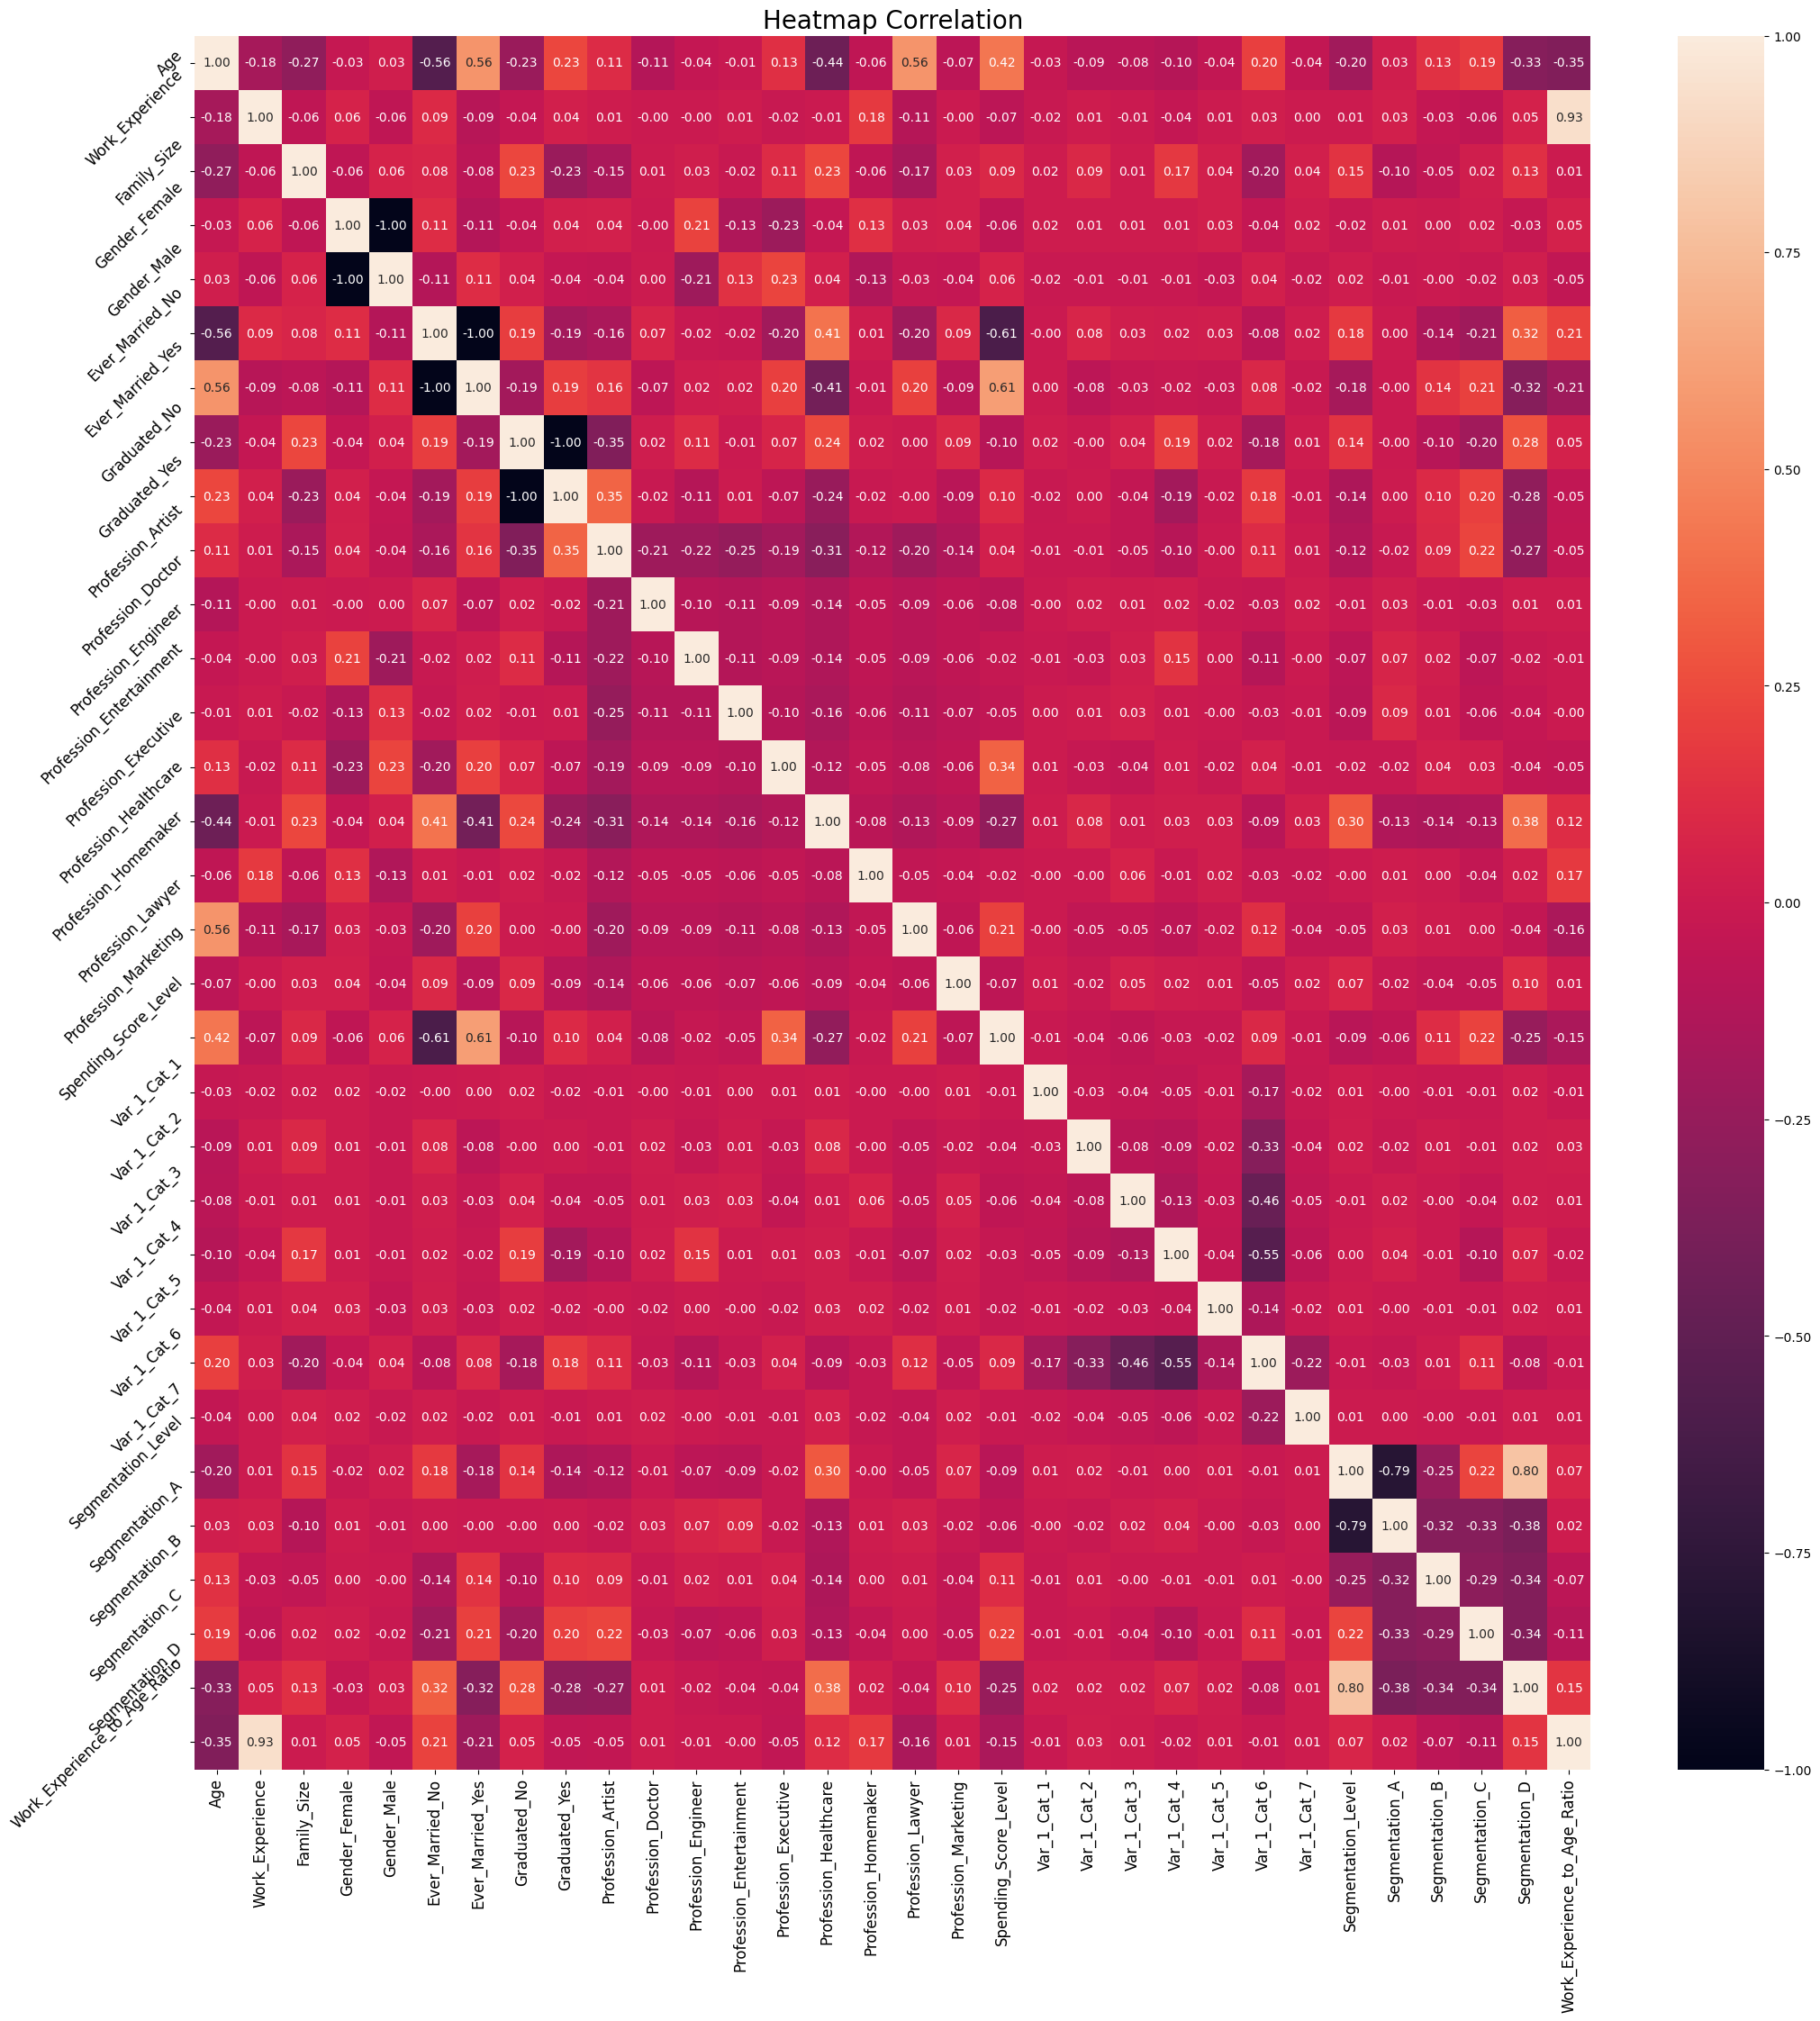

In [ ]:
fig, axarr = plt.subplots(5, 2, figsize=(30, 18))
sns.countplot(x="Gender", hue = "Segmentation", data = df, ax=axarr[0][0])
sns.countplot(x="Ever_Married", hue = "Segmentation", data = df, ax=axarr[0][1])
sns.countplot(x="Graduated", hue = "Segmentation", data = df, ax=axarr[1][0])
sns.countplot(x="Profession", hue = "Segmentation", data = df, ax=axarr[1][1])
sns.countplot(x="Spending_Score", hue = "Segmentation", data = df, ax=axarr[2][0])
sns.countplot(x="Var_1", hue = "Segmentation", data = df, ax=axarr[2][1])
sns.countplot(x="Age_Range", hue = "Segmentation", data = df, ax=axarr[3][0])
sns.countplot(x="Work_Experience_Range", hue = "Segmentation", data = df, ax=axarr[3][1])
sns.countplot(x="Family_Size_Range", hue = "Segmentation", data = df, ax=axarr[4][0])
sns.countplot(x="Work_Experience_to_Age_Ratio_Range", hue = "Segmentation", data = df, ax=axarr[4][1])

df.drop(["Segmentation", "Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1", "Age_Range",
              "Work_Experience_Range", "Family_Size_Range", "Work_Experience_to_Age_Ratio_Range"], axis=1, inplace=True)

fig, ax = plt.subplots(1, figsize=(25,25))
sns.heatmap(df.corr(), annot=True, fmt=",.2f")
plt.title("Heatmap Correlation", fontsize=20)
plt.tick_params(labelsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df[["Age", "Family_Size", "Profession_Healthcare", "Profession_Entertainment", "Profession_Artist", "Ever_Married_Yes",
             "Graduated_No", "Spending_Score_Level"]]
y = df["Segmentation_Level"]

sc_X = MinMaxScaler()
X_scaled = sc_X.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0)



Testing neighbors:
Neighbors: 1, F1 Score: 0.370
Neighbors: 2, F1 Score: 0.366
Neighbors: 3, F1 Score: 0.393
Neighbors: 4, F1 Score: 0.414
Neighbors: 5, F1 Score: 0.420
Neighbors: 6, F1 Score: 0.426
Neighbors: 7, F1 Score: 0.427
Neighbors: 8, F1 Score: 0.422
Neighbors: 9, F1 Score: 0.427
Neighbors: 10, F1 Score: 0.425
Neighbors: 11, F1 Score: 0.431
Neighbors: 12, F1 Score: 0.440
Neighbors: 13, F1 Score: 0.442
Neighbors: 14, F1 Score: 0.442
Neighbors: 15, F1 Score: 0.446

Best number of neighbors: 15 with F1 Score: 0.446



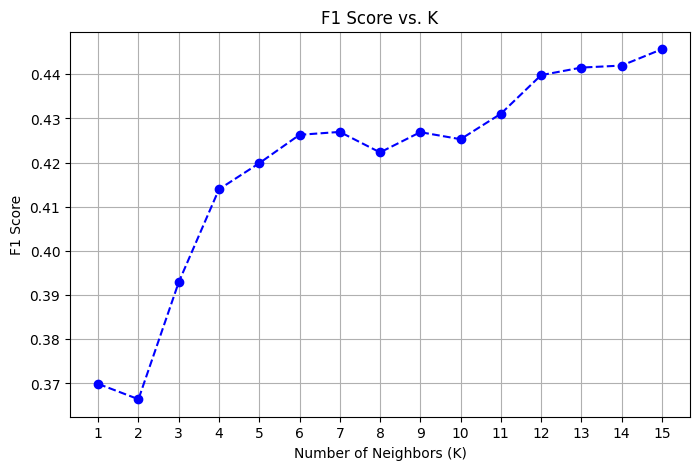

Final Model Performance:
Train: Accuracy: 0.518, Precision: 0.514, Recall: 0.518, F1: 0.514
Test : Accuracy: 0.450, Precision: 0.446, Recall: 0.450, F1: 0.446

Confusion Matrix:
Predicted    1    2    3    4
Actual                       
1          294  142   93  177
2          182  184  170   98
3          146  101  278   77
4          178   49   53  443


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Range of neighbors to test
n_neighbors = range(1, 16)

# Store metrics for each k
metrics = []

# Find the best k based on F1 score
best_k = 0
best_f1 = 0

print("Testing neighbors:")
for k in n_neighbors:
    model_knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_preds_test = model_knn.predict(X_test)
    f1_test = f1_score(y_test, y_preds_test, average="weighted")
    metrics.append(f1_test)

    if f1_test > best_f1:  # Update the best k
        best_f1 = f1_test
        best_k = k

    print(f"Neighbors: {k}, F1 Score: {f1_test:.3f}")

print(f"\nBest number of neighbors: {best_k} with F1 Score: {best_f1:.3f}\n")

# Plot F1 Score vs. Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(n_neighbors, metrics, marker="o", linestyle="--", color="b")
plt.title("F1 Score vs. K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("F1 Score")
plt.xticks(n_neighbors)
plt.grid()
plt.show()

# Train final model with the best k
model_knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
y_preds_train = model_knn.predict(X_train)
y_preds_test = model_knn.predict(X_test)

# Calculate performance metrics for the chosen k
accuracy_train = accuracy_score(y_train, y_preds_train)
accuracy_test = accuracy_score(y_test, y_preds_test)
precision_train = precision_score(y_train, y_preds_train, average="weighted")
precision_test = precision_score(y_test, y_preds_test, average="weighted")
recall_train = recall_score(y_train, y_preds_train, average="weighted")
recall_test = recall_score(y_test, y_preds_test, average="weighted")
f1_train = f1_score(y_train, y_preds_train, average="weighted")
f1_test = f1_score(y_test, y_preds_test, average="weighted")

print("Final Model Performance:")
print(f"Train: Accuracy: {accuracy_train:.3f}, Precision: {precision_train:.3f}, Recall: {recall_train:.3f}, F1: {f1_train:.3f}")
print(f"Test : Accuracy: {accuracy_test:.3f}, Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1: {f1_test:.3f}")

# Confusion Matrix
confusion_matrix = pd.crosstab(y_test, y_preds_test, rownames=["Actual"], colnames=["Predicted"])
print("\nConfusion Matrix:")
print(confusion_matrix)

# Add predictions to the dataset and save to CSV
y_preds_all = model_knn.predict(X_scaled)
df["Segmentation_Level_predicted"] = y_preds_all
df[["Segmentation_Level_predicted", "Segmentation_Level"]].to_csv("predictions.csv", index=False)



In [ ]:
#training accuracy
print(accuracy_train*100)
#testing accuracy
print(accuracy_test*100)


51.789289289289286
44.9906191369606
